In [1]:
# Imports
import re
import string
from collections import Counter

import pandas as pd
import numpy as np
from gensim.summarization import keywords
import matplotlib.pyplot as plt

In [ ]:
#install pdf reader module
#! pip install pdfminer.six

## load job descriptions data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/job_descriptions.csv', encoding = 'unicode_escape')
df.head()

In [ ]:
#clean text
def clean_text(text):
    text = text.replace('\n', ' ')                # remove newline
    text = text.replace(':', ' ')
    return text
df['description'] = df.apply(lambda x: clean_text(x['jobOrResumeDescription']), axis=1)

In [ ]:
jd = df['description'].tolist()

Build model to tag each job description as a seperate document.

In [ ]:
import gensim
import gensim.downloader as api
from gensim import models
# Create the tagged document needed for Doc2Vec
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

train_data = list(create_tagged_document(jd))

Train the model on the job descriptions for matching later.

In [ ]:
# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

# Build the Volabulary
model.build_vocab(train_data)

# Train the Doc2Vec model
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

Here we apply the model to each job description in the corpus.

In [ ]:
data = []
for i in range(len(jd)):
    data.append(model.docvecs[i])

## Now let's load the text from our resume

In [ ]:
resume = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/resumes.csv', encoding = 'unicode_escape')
resume.head()

,jobOrResumeDescription,role,sourceType,description
0,Â with around 5 years of experience in all p...,Data Scientist,resume,Â with around 5 years of experience in all p...
1,\n \nData scientist with a strong math backgro...,Data Scientist,resume,Data scientist with a strong math backgroun...
2,\n\n\n* Around 4+ years of experience in Data...,Data Scientist,resume,* Around 4+ years of experience in Data An...
3,\n\nExpert in logical and problem-solving wit...,Data Scientist,resume,Expert in logical and problem-solving with ...
4,Experienced with 2+ years of hands-on experie...,Data Scientist,resume,Experienced with 2+ years of hands-on experie...


We only need one resume to start with so let's select the first one and split into words to push into our model.

In [ ]:
r1 = resume['description'].iloc[0]

In [ ]:
resume = resume['description'].iloc[0].split()

Review the resulting vector.

In [ ]:
print(model.infer_vector(resume))

[-0.2703119   0.46140584  1.3335586   0.194047    0.3511251  -0.05135229
  1.2376658   1.104154    0.6905708  -0.66995645  0.00775168  1.7607471
 -0.56709665  0.71579945  1.4739642  -0.98076457 -0.70780426  0.93041635
 -0.38668808  0.03639724 -0.569789    0.30209452  1.1538218  -0.1179663
 -0.64267266 -0.57093453  0.14116059 -0.3806373   0.542782   -0.4670417
 -0.9182177  -0.00489526  2.1500022  -0.5747738   0.09500379 -0.12688264
  0.07573358  0.37014386 -1.56851     0.15511167 -0.06379291 -0.63691014
  0.957231    1.1769577  -1.1278763   0.05250629  0.93851274  0.62922686
 -0.03870421 -0.44639188]


In [ ]:
resume_vect = model.infer_vector(resume)

## Compare our resume to the job descriptions using PCA

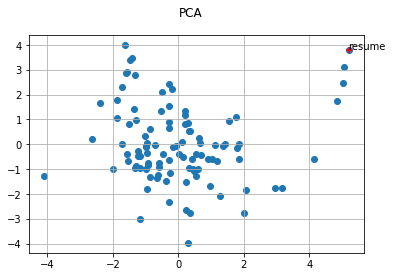

In [ ]:
def plot_pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2) #, whiten=True
    X = pca.fit_transform(data)
    xs,ys =X[:,0], X[:,1]
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.grid()
    plt.suptitle('PCA')
    #plt.savefig('distance_PCA_improved.png')
    plt.show()
plot_pca(data)

## Calculate the cosine distances between our resume and each of the job descriptions

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
cos_dist =[]
for i in range(len(data)):
    cos_dist.append(float(cosine_distances(resume_vect[0:].reshape(1,-1),data[i].reshape(1,-1))))

create a key words list for each job description

In [ ]:
key_list =[]

for j in jd:
    key =''
    for word in keywords(j).split('\n'):
        key += '{} '.format(word)
    key_list.append(key)

Create a nice data frame to put the scores and keywords together. Print out the first 10 lowest scores. Those jobs will the most similar to the resume.

In [ ]:
role = df['role'].tolist()
summary = pd.DataFrame({
        'Role Title': role,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
        'Job Description': jd
    })
z = summary.sort_values(by ='Cosine Distances', ascending=True)
z.head(10)

,Role Title,Cosine Distances,Keywords,Job Description
34,Data Scientist,0.408452,knowledge engineer experience learning data th...,- Data Scientist / Data Engineer - Chica...
35,Data Scientist,0.493039,knowledge experience learning scientist theano,"Data Scientist Chicago, IL Contract &..."
20,Data Scientist,0.605699,experience data lead leading time bdm field di...,Big Data Lead Raritan- NJ -12 months ...
30,Data Scientist,0.616657,experience experiments data models model model...,"Data Scientist Richardson, TX Full T..."
98,Data Engineer,0.632020,computational high computing numerical methods...,Applied Computational Mathematician / Engineer...
76,Data Analyst,0.661276,solutions like perform alternative solution pr...,"Sr. Business Analyst UC Innovation - Irvine, C..."
72,Data Analyst,0.680710,data experience including providing business m...,Senior Healthcare Data Analyst Advantmed98 re ...
24,Data Scientist,0.688905,experience data business solutions strong team...,"-Lead BI - Cheektowaga, NY -Full Time ..."
0,Developer,0.692190,years developer development developing sql ser...,Artificial Intelligence / Machine Learning D...
37,Data Engineer,0.719788,data processing process models good solutions ...,"Big Data Architect DE, PA, NJ, NYC, MA s (50-6..."


Let's print the first job description and our resume text to visually compare.

In [ ]:
z['Job Description'].iloc[0]

'   - Data Scientist / Data Engineer    - Chicago, IL    - Long Term  Exp Req  - 8+ Years        -      Senior data scientist / engineer      Financial Domain Knowledge & experience     Strong Experience in AI related      Knowledge & exposure in rendering ML functionality     Understanding  AI/Deep Learning algorithm such as CNN, RNN, LSTM     Experience in building AI based NLP and OCR solution using Keras, Google Tensorflow, Theano, Caffe 2 etc? '